In [ ]:
#importazione librerie
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats, interpolate
from scipy.ndimage import gaussian_filter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, r2_score
from scipy.ndimage import gaussian_filter
try:
  from mplsoccer.pitch import Pitch, VerticalPitch
  from mplsoccer import PyPizza, Radar
  from highlight_text import fig_text
except:
  !pip install mplsoccer
  !pip install highlight_text
  from mplsoccer import PyPizza, Radar
  from mplsoccer.pitch import Pitch, VerticalPitch
  from highlight_text import fig_text

PREPARAZIONE DATI

In [2]:
#importazione dati piede preferito e preprazione dati
df_foot = pd.read_csv('database_foot_serieA_2021-22.csv')
df_foot.sort_values('known_name').head(20)

df_id = pd.read_csv('player_id_serieA_2021-22.csv')
df_id.sort_index().head(20)

df5 = df_foot.merge(df_id, how = 'outer')

df5.to_csv('Foot_player.csv')

df_foot_player = pd.read_csv('Foot_player.csv')
df_foot_player.rename(columns={'Foot':'Foot_type'}, inplace =True)
df_foot_player1 = df_foot_player.drop(['Unnamed: 0','Player_Name', 'Player_LastName', 'first_name', 'last_name', 'born_date'], axis = 1)
df_foot_player1 = df_foot_player1.reindex(columns=['sics_id','opta_id','sc_id','known_name','Club','Position', 'Foot_type']) #dataset foot_player rearranged

df_foot_player2 = df_foot_player1.set_index('sics_id')

In [ ]:
#caricamento dataset eventi Serie A e preparazione dati
df = pd.read_csv('SICS-Serie A 2021-22_eventi.csv', sep=';').fillna(0)

df = df[df['ID Giocatori'] != 0] 
df1_nz = df.drop(['Unnamed: 25'], axis = 1) 
df1_nz = df1_nz[df1_nz.Descrizione == 'Palle Inattive Favore']
df1_nz['ID Giocatori'] = pd.to_numeric(df1_nz['ID Giocatori'])
df2_nz = df1_nz.set_index('ID Giocatori')

In [ ]:
#unione e preparazione dataset finale
dfm = df2_nz.merge(df_foot_player2, left_index = True, right_index = True, how = 'outer')

dfm.fillna(0)
dfm = dfm.dropna(0)
dfm = dfm.rename_axis('sics_id')

dfm.rename(columns={'Esito':'n_eventi'}, inplace =True)

dfm = dfm.reindex(columns=['opta_id', 'sc_id','Giocatori','Squadra', 'Position', 'Foot_type', 'Giornata', 'Partita', 'Data','Descrizione',
                           'Tags', 'P0 x', 'P0 y', 'P1 x', 'P1 y', 'P0 norm x', 'P0 norm y', 'P1 norm x', 'P1 norm y', 'n_eventi'])
dfm['n_eventi'] = dfm.n_eventi.replace(0, 1)
dfm['n_eventi'] = pd.to_numeric(dfm['n_eventi']) 


CLASSIFICAZIONE GRUPPI

In [ ]:
#situazioni da corner
dfm_dx = dfm[(dfm['P0 norm x'] > 103.) & (dfm['P0 norm y'] < 2.)] #angolo dx
dfm_sx = dfm[(dfm['P0 norm x'] > 103.) & (dfm['P0 norm y'] > 66.)] #angolo sx

data = [dfm_dx,dfm_sx]

dfm_tot = pd.concat(data)

dfm_tot

#3654 SITUAZIONI DA CALCIO D'ANGOLO di cui:
  # - 1749 da destra
  # - 1905 da sinistra

In [ ]:
groups1 = ['Palle inattive','Angoli']
sizes_3 = [dfm['n_eventi'].sum(),dfm_tot['n_eventi'].sum()]
explode = (0,0.1)
fig1, ax = plt.subplots()
ax.pie(sizes_3, explode=explode, labels=groups1, autopct='%1.2f%%',
        shadow=True, startangle=90, counterclock=False)
ax.axis('equal')
plt.show()

In [ ]:
#angolo dx
dfm_dx = dfm[(dfm['P0 norm x'] > 103.) & (dfm['P0 norm y'] < 2.)] 
dfm_dx1 = dfm_dx.groupby('Giocatori').sum()
dfm_dx1
#150 battitori da calcio d'angolo da destra

In [ ]:
#angolo sx
dfm_sx = dfm[(dfm['P0 norm x'] > 103.) & (dfm['P0 norm y'] > 66.)] 
dfm_sx1 = dfm_sx.groupby('Giocatori').sum()
dfm_sx1
#164 battitori da calcio d'angolo da sinistra

In [ ]:
groups = ['Angoli dx','Angolo sx']
sizes_2 = [dfm_dx1['n_eventi'].sum(),dfm_sx1['n_eventi'].sum()]
explode = (0,0.1)
fig1, ax = plt.subplots()
ax.pie(sizes_2, explode=explode, labels=groups, autopct='%1.2f%%',
        shadow=True, startangle=90, counterclock=False)
ax.axis('equal')
plt.show()

In [ ]:
#passsaggi in aerea da angolo dx
dfm_indx = dfm[(dfm['P0 norm x'] > 103.) & (dfm['P0 norm y'] < 2.)]
dfm_dx_in = dfm_indx[(dfm_indx['P1 norm x'] <= 105.) & (dfm_indx['P1 norm x'] >= 88.5) & (dfm_indx['P1 norm y'] <= 54.) & (dfm_indx['P1 norm y'] >= 14.)]
dfm_dx_in1 = dfm_dx_in.groupby('Giocatori').sum()
dfm_dx_in1
#132 battitori da calcio d'angolo da destra

In [ ]:
#passsaggi in aerea da angolo sx
dfm_insx = dfm[(dfm['P0 norm x'] > 103.) & (dfm['P0 norm y'] > 66.)] 
dfm_sx_in = dfm_insx[(dfm_insx['P1 norm x'] <= 105.) & (dfm_insx['P1 norm x'] >= 88.5) & (dfm_insx['P1 norm y'] <= 54.) & (dfm_insx['P1 norm y'] >= 14.)]
dfm_sx_in1 = dfm_sx_in.groupby('Giocatori').sum()
dfm_sx_in1
#144 battitori da calcio d'angolo da sinistra

In [ ]:
groups = ['Angoli dx','Angolo sx']
sizes_2 = [dfm_dx_in1['n_eventi'].sum(),dfm_sx_in1['n_eventi'].sum()]
explode = (0,0.1)
fig1, ax = plt.subplots()
ax.pie(sizes_2, explode=explode, labels=groups, autopct='%1.2f%%',
        shadow=True, startangle=90, counterclock=False)
ax.axis('equal')
plt.show()

In [ ]:
dfm = dfm[dfm.Foot_type != 'both'] #non considero giocatori ambidestri perchè non è possibile verificare con quale piede hanno battuto il corner

In [ ]:
#GRUPPO A : angolo dx, piede dx (effetto a uscire) palla dentro area
dfm_A = dfm[(dfm['P0 norm x'] > 103.) & (dfm['P0 norm y'] < 2.) & (dfm.Foot_type == 'right')]
dfm_A1 = dfm_A[(dfm_A['P1 norm x'] <= 105.) & (dfm_A['P1 norm x'] >= 88.5) & (dfm_A['P1 norm y'] <= 54.) & (dfm_A['P1 norm y'] >= 14.)]
dfm_A1['mean_x'] = dfm_A1['P1 norm x'].mean()
dfm_A1['mean_y'] = dfm_A1['P1 norm y'].mean()
dfm_A1

#GRUPPO B : angolo dx, piede sx (effetto a rientrare) palla dentro area
dfm_B = dfm[(dfm['P0 norm x'] > 103.) & (dfm['P0 norm y'] < 2.) & (dfm.Foot_type == 'left')]
dfm_B1 = dfm_B[(dfm_B['P1 norm x'] <= 105.) & (dfm_B['P1 norm x'] >= 88.5) & (dfm_B['P1 norm y'] <= 54.) & (dfm_B['P1 norm y'] >= 14.)]
dfm_B1['mean_x'] = dfm_B1['P1 norm x'].mean()
dfm_B1['mean_y'] = dfm_B1['P1 norm y'].mean()
dfm_B1

# #GRUPPO C : angolo sx, piede sx (effetto a uscire) palla dentro area
dfm_C = dfm[(dfm['P0 norm x'] > 103.) & (dfm['P0 norm y'] > 66.) & (dfm.Foot_type == 'left')] 
dfm_C1 = dfm_C[(dfm_C['P1 norm x'] <= 105.) & (dfm_C['P1 norm x'] >= 88.5) & (dfm_C['P1 norm y'] <= 54.) & (dfm_C['P1 norm y'] >= 14.)]
dfm_C1['mean_x'] = dfm_C1['P1 norm x'].mean()
dfm_C1['mean_y'] = dfm_C1['P1 norm y'].mean()
dfm_C1

# #GRUPPO D : angolo sx, piede dx (effetto a rientrare) palla dentro area
dfm_D = dfm[(dfm['P0 norm x'] > 103.) & (dfm['P0 norm y'] > 66.) & (dfm.Foot_type == 'right')] 
dfm_D1 = dfm_D[(dfm_D['P1 norm x'] <= 105.) & (dfm_D['P1 norm x'] >= 88.5) & (dfm_D['P1 norm y'] <= 54.) & (dfm_D['P1 norm y'] >= 14.)]
dfm_D1['mean_x'] = dfm_D1['P1 norm x'].mean()
dfm_D1['mean_y'] = dfm_D1['P1 norm y'].mean()
dfm_D1


In [ ]:
groups = ['Gruppo A','Gruppo B','Gruppo C','Gruppo D']
sizes_2 = [dfm_A1['n_eventi'].sum(),dfm_B1['n_eventi'].sum(),dfm_C1['n_eventi'].sum(),dfm_D1['n_eventi'].sum()]
explode= (0.05,0.05,0.05,0.05)
fig1, ax = plt.subplots()
ax.pie(sizes_2, explode=explode, labels=groups, autopct='%1.2f%%',
        shadow=True, startangle=90, counterclock=False)
ax.axis('equal')
plt.show()

In [ ]:
pitch = VerticalPitch(pitch_type = 'uefa', half =True, line_color = 'black', line_zorder=1,pad_left=-12,pad_right=-12,pad_bottom=-30)

f1, ax1 = plt.subplots(nrows = 1, ncols = 2, figsize = (15,20), squeeze = False) 

#gruppo A
pitch.draw(ax = ax1[0][0])
bin_statistic = pitch.bin_statistic(dfm_A1['P1 norm x'], dfm_A1['P1 norm y'], statistic='count', bins=(150,150))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 2)
pcm = pitch.heatmap(bin_statistic, cmap = 'Blues' , ax=ax1[0][0])

pitch.scatter(x = dfm_A1['P1 norm x'], 
              y = dfm_A1['P1 norm y'], 
              s = 2,
              color = 'black', 
              edgecolor = 'black',
              zorder = 1,
              alpha = 0.1, 
              ax = ax1[0][0])

pitch.plot(dfm_A1['mean_x'], np.linspace(0, 68, len(dfm_A1['P1 norm y'])),ax1[0][0], color = 'blue', ls = '-.')
pitch.plot(np.linspace(0, 105, len(dfm_A1['P1 norm x'])), dfm_A1['mean_y'], ax1[0][0], color = 'blue', ls = '-.')

ax1[0][0].set_title('GRUPPO A\n angolo dx, piede dx\n (effetto a uscire)')


#gruppo B
pitch.draw(ax = ax1[0][1])
bin_statistic = pitch.bin_statistic(dfm_B1['P1 norm x'], dfm_B1['P1 norm y'], statistic='count', bins=(150,150))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 2)
pcm = pitch.heatmap(bin_statistic, cmap = 'Oranges' , ax=ax1[0][1])

pitch.scatter(x = dfm_B1['P1 norm x'], 
              y = dfm_B1['P1 norm y'], 
              s = 2,
              color = 'black', 
              edgecolor = 'black',
              zorder = 1,
              alpha = 0.1, 
              ax = ax1[0][1])

pitch.plot(dfm_B1['mean_x'], np.linspace(0, 68, len(dfm_B1['P1 norm y'])),ax1[0][1], color = 'orange', ls = '-.')
pitch.plot(np.linspace(105, 0, len(dfm_B1['P1 norm x'])), dfm_B1['mean_y'] ,ax1[0][1], color = 'orange', ls = '-.')

ax1[0][1].set_title("'GRUPPO B\n angolo dx, piede sx\n (effetto a rientrare)'")

plt.subplots_adjust(wspace = 0.1, hspace = 0.) 
plt.show()

f2, ax2 = plt.subplots(nrows = 1, ncols = 2, figsize = (15,20), squeeze = False) 

#gruppo C
pitch.draw(ax = ax2[0][0])
bin_statistic = pitch.bin_statistic(dfm_C1['P1 norm x'], dfm_C1['P1 norm y'], statistic='count', bins=(150,150))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 2)
pcm = pitch.heatmap(bin_statistic, cmap = 'Greens' , ax=ax2[0][0])

pitch.scatter(x = dfm_C1['P1 norm x'], 
              y = dfm_C1['P1 norm y'], 
              s = 2,
              color = 'black', 
              edgecolor = 'black',
              zorder = 1,
              alpha = 0.1, 
              ax = ax2[0][0])

pitch.plot(dfm_C1['mean_x'], np.linspace(0, 68, len(dfm_C1['P1 norm y'])),ax2[0][0], color = 'green', ls = '-.')
pitch.plot(np.linspace(0, 105, len(dfm_C1['P1 norm x'])), dfm_C1['mean_y'],ax2[0][0], color = 'green', ls = '-.')

ax2[0][0].set_title('GRUPPO C\n angolo sx, piede sx\n (effetto a uscire)')

#gruppo D
pitch.draw(ax = ax2[0][1])
bin_statistic = pitch.bin_statistic(dfm_D1['P1 norm x'], dfm_D1['P1 norm y'], statistic='count', bins=(150,150))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 2)
pcm = pitch.heatmap(bin_statistic, cmap = 'Reds' , ax=ax2[0][1])

pitch.scatter(x = dfm_D1['P1 norm x'], 
              y = dfm_D1['P1 norm y'], 
              s = 2,
              color = 'black', 
              edgecolor = 'black',
              zorder = 1,
              alpha = 0.1, 
              ax = ax2[0][1])

pitch.plot(dfm_D1['mean_x'], np.linspace(0, 68, len(dfm_D1['P1 norm y'])),ax2[0][1], color = 'red', ls = '-.')
pitch.plot(np.linspace(0, 105, len(dfm_D1['P1 norm x'])), dfm_D1['mean_y'],ax2[0][1], color = 'red', ls = '-.')

ax2[0][1].set_title('GRUPPO D\nangolo sx, piede dx\n(effetto a rientrare)')

plt.subplots_adjust(wspace = 0.1, hspace = 0.15) 

plt.show()

CONVERSION RATE

In [ ]:
#gruppo A
dfm_A1['assist_scA'] = (dfm_A1.Tags != 'Corner Fatto').astype(int) 
dfm_A1['assist_scA'].value_counts(normalize = True)

#gruppo B
dfm_B1['assist_scB'] = (dfm_B1.Tags != 'Corner Fatto').astype(int) 
dfm_B1['assist_scB'].value_counts(normalize = True)

#gruppo C
dfm_C1['assist_scC'] = (dfm_C1.Tags != 'Corner Fatto').astype(int) 
dfm_C1['assist_scC'].value_counts(normalize = True)

#gruppo D
dfm_D1['assist_scD'] = (dfm_D1.Tags != 'Corner Fatto').astype(int) 
dfm_D1['assist_scD'].value_counts(normalize = True)


In [ ]:
pitch = VerticalPitch(pitch_type = 'uefa', half =True, line_color = 'black', line_zorder=1,pad_left=-12,pad_right=-12,pad_bottom=-30)

f1, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,20), squeeze = False)

pitch.draw(ax = ax[0][0])
asA_conv = pitch.bin_statistic(dfm_A1['P1 norm x'], dfm_A1['P1 norm y'], dfm_A1.assist_scA, statistic='mean', bins=(40,30))
asA_count = pitch.bin_statistic(dfm_A1['P1 norm x'], dfm_A1['P1 norm y'], statistic='count', bins=(40,30))
pcm = pitch.heatmap(asA_conv, cmap='Blues', ax=ax[0][0])
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01, ax=ax[0][0])
labels = pitch.label_heatmap(asA_count, color='black',fontsize = 10,
                             ax=ax[0][0], ha='center', va='center',
                             str_format='{:.0f}')
ax[0][0].set_title('Gruppo A')

pitch.draw(ax = ax[0][1])
asB_conv = pitch.bin_statistic(dfm_B1['P1 norm x'], dfm_B1['P1 norm y'], dfm_B1.assist_scB, statistic='mean', bins=(40,30))
asB_count = pitch.bin_statistic(dfm_B1['P1 norm x'], dfm_B1['P1 norm y'], statistic='count', bins=(40,30))
labels = pitch.label_heatmap(asB_count, color='black',fontsize = 10,
                             ax=ax[0][1], ha='center', va='center',
                             str_format='{:.0f}')
pcm = pitch.heatmap(asB_conv, cmap='Oranges', ax=ax[0][1])
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01, ax=ax[0][1])

ax[0][1].set_title('Gruppo B')

pitch.draw(ax = ax[1][0])
asC_conv = pitch.bin_statistic(dfm_C1['P1 norm x'], dfm_C1['P1 norm y'], dfm_C1.assist_scC, statistic='mean', bins=(40,30))
asC_count = pitch.bin_statistic(dfm_C1['P1 norm x'], dfm_C1['P1 norm y'], statistic='count', bins=(40,30))
labels = pitch.label_heatmap(asC_count, color='black',fontsize = 10,
                             ax=ax[1][0], ha='center', va='center',
                             str_format='{:.0f}')
pcm = pitch.heatmap(asC_conv, cmap='Greens', ax=ax[1][0])
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01, ax=ax[1][0])

ax[1][0].set_title('Gruppo C')

pitch.draw(ax = ax[1][1])
asD_conv = pitch.bin_statistic(dfm_D1['P1 norm x'], dfm_D1['P1 norm y'], dfm_D1.assist_scD, statistic='mean', bins=(40,30))
asD_count = pitch.bin_statistic(dfm_D1['P1 norm x'], dfm_D1['P1 norm y'], statistic='count', bins=(40,30))
labels = pitch.label_heatmap(asD_count, color='black',fontsize = 10,
                             ax=ax[1][1], ha='center', va='center',
                             str_format='{:.0f}')
pcm = pitch.heatmap(asD_conv, cmap='Reds', ax=ax[1][1])
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01, ax=ax[1][1])

ax[1][1].set_title('Gruppo D')

plt.subplots_adjust(wspace = 0.1, hspace = 0.15) 

plt.show()

RELAZIONE TRA CONVERSION RATE E VARIABILI PREDITTIVE

In [ ]:
#gruppo A
lA = dfm_A1['mean_x'].mean()
hA = dfm_A1['mean_y'].mean()

dfm_A1['xassist_scA'] = lA - dfm_A1['P1 norm x']
dfm_A1['yassist_scA'] = dfm_A1['P1 norm y'] - hA

dfm_A1['distanceA'] = np.sqrt(dfm_A1.xassist_scA**2 + dfm_A1.yassist_scA**2)

gsize = 10.08 #
dfm_A1['angleA'] = np.arctan(gsize *dfm_A1.xassist_scA /(dfm_A1.xassist_scA**2 + dfm_A1.yassist_scA**2 - (gsize/2)**2))

#gruppo B
lB = dfm_B1['mean_x'].mean()
hB = dfm_B1['mean_y'].mean()

dfm_B1['xassist_scB'] = lB - dfm_B1['P1 norm x']
dfm_B1['yassist_scB'] = dfm_B1['P1 norm y'] - hB

dfm_B1['distanceB'] = np.sqrt(dfm_B1.xassist_scB**2 + dfm_B1.yassist_scB**2)

gsize = 10.08
dfm_B1['angleB'] = np.arctan(gsize *dfm_B1.xassist_scB /(dfm_B1.xassist_scB**2 + dfm_B1.yassist_scB**2 - (gsize/2)**2))

#gruppo C
lC = dfm_C1['mean_x'].mean()
hC = dfm_C1['mean_y'].mean()

dfm_C1['xassist_scC'] = lC - dfm_C1['P1 norm x']
dfm_C1['yassist_scC'] = dfm_C1['P1 norm y'] - hC

dfm_C1['distanceC'] = np.sqrt(dfm_C1.xassist_scC**2 + dfm_C1.yassist_scC**2)

gsize = 10.08
dfm_C1['angleC'] = np.arctan(gsize *dfm_C1.xassist_scC /(dfm_C1.xassist_scC**2 + dfm_C1.yassist_scC**2 - (gsize/2)**2))

#gruppo D
lD = dfm_D1['mean_x'].mean()
hD = dfm_D1['mean_y'].mean()

dfm_D1['xassist_scD'] = lD - dfm_D1['P1 norm x']
dfm_D1['yassist_scD'] = dfm_D1['P1 norm y'] - hD

dfm_D1['distanceD'] = np.sqrt(dfm_D1.xassist_scD**2 + dfm_D1.yassist_scD**2)

gsize = 10.08
dfm_D1['angleD'] = np.arctan(gsize *dfm_D1.xassist_scD /(dfm_D1.xassist_scD**2 + dfm_D1.yassist_scD**2 - (gsize/2)**2))

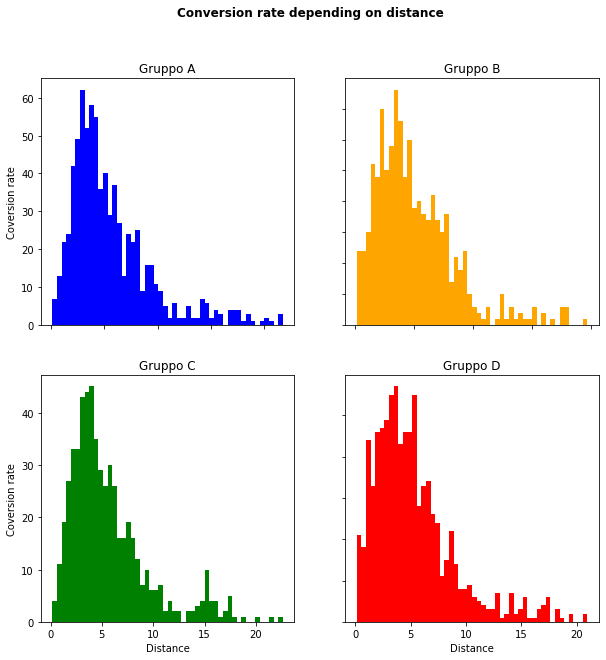

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
fig.suptitle('Conversion rate depending on distance', weight = 'bold')
ax1.hist(dfm_A1.distanceA, bins =50, color = 'blue')
ax1.set_title('Gruppo A')
ax2.hist(dfm_B1.distanceB, bins =50, color = 'orange')
ax2.set_title('Gruppo B')
ax3.hist(dfm_C1.distanceC, bins =50, color = 'green')
ax3.set_title('Gruppo C')
ax4.hist(dfm_D1.distanceD, bins =50, color = 'red')
ax4.set_title('Gruppo D')
ax1.set_xlabel('Distance')

for ax in fig.get_axes():
    ax.set(xlabel='Distance', ylabel='Coversion rate')

for ax in fig.get_axes():
  ax.label_outer()

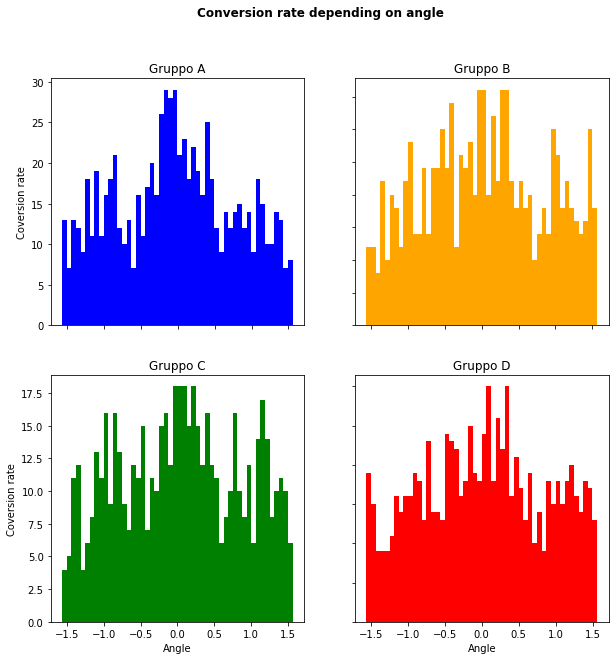

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
fig.suptitle('Conversion rate depending on angle', weight = 'bold')
ax1.hist(dfm_A1.angleA, bins =50, color = 'blue')
ax1.set_title('Gruppo A')
ax2.hist(dfm_B1.angleB, bins =50, color = 'orange')
ax2.set_title('Gruppo B')
ax3.hist(dfm_C1.angleC, bins =50, color = 'green')
ax3.set_title('Gruppo C')
ax4.hist(dfm_D1.angleD, bins =50, color = 'red')
ax4.set_title('Gruppo D')

for ax in fig.get_axes():
    ax.set(xlabel='Angle', ylabel='Coversion rate')

for ax in fig.get_axes():
  ax.label_outer()

IMPLEMENTAZIONE MODELLO STATISTICO DI REGRESSIONE LOGISTICA

In [ ]:
#gruppo A
XA = dfm_A1[['distanceA', 'angleA']].values
yA = dfm_A1.assist_scA.values

clfA = LogisticRegression()
clfA.fit(XA,yA)

dfm_A1['xA_scA'] = clfA.predict_proba(XA)[:,1]

#gruppo B
XB = dfm_B1[['distanceB', 'angleB']].values
yB = dfm_B1.assist_scB.values

clfB = LogisticRegression()
clfB.fit(XB,yB)

dfm_B1['xA_scB'] = clfB.predict_proba(XB)[:,1]

#gruppo C
XC = dfm_C1[['distanceC', 'angleC']].values
yC = dfm_C1.assist_scC.values

clfC = LogisticRegression()
clfC.fit(XC,yC)

dfm_C1['xA_scC'] = clfC.predict_proba(XC)[:,1]

#gruppo D
XD = dfm_D1[['distanceD', 'angleD']].values
yD = dfm_D1.assist_scD.values

clfD = LogisticRegression()
clfD.fit(XD,yD)

dfm_D1['xA_scD'] = clfD.predict_proba(XD)[:,1]


In [ ]:
pitch = VerticalPitch(pitch_type = 'uefa', half =True, line_color = 'black', line_zorder=1,pad_left=-12,pad_right=-12,pad_bottom=-30)

f1, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,20), squeeze = False)

pitch.draw(ax = ax[0][0])
bin_statistic = pitch.bin_statistic(dfm_A1['P1 norm x'], dfm_A1['P1 norm y'], dfm_A1.xA_scA, statistic='mean', bins=(100,100))
pcm = pitch.heatmap(bin_statistic, cmap='Blues', ax=ax[0][0])
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01, ax=ax[0][0])
ax[0][0].set_title('Gruppo A')

pitch.draw(ax = ax[0][1])
bin_statistic = pitch.bin_statistic(dfm_B1['P1 norm x'], dfm_B1['P1 norm y'], dfm_B1.xA_scB, statistic='mean', bins=(100,100))
pcm = pitch.heatmap(bin_statistic, cmap='Oranges', ax=ax[0][1])
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01, ax=ax[0][1])
ax[0][1].set_title('Gruppo B')

pitch.draw(ax = ax[1][0])
bin_statistic = pitch.bin_statistic(dfm_C1['P1 norm x'], dfm_C1['P1 norm y'], dfm_C1.xA_scC, statistic='mean', bins=(100,100))
pcm = pitch.heatmap(bin_statistic, cmap='Greens', ax=ax[1][0])
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01, ax=ax[1][0])
ax[1][0].set_title('Gruppo C')

pitch.draw(ax = ax[1][1])
bin_statistic = pitch.bin_statistic(dfm_D1['P1 norm x'], dfm_D1['P1 norm y'], dfm_D1.xA_scD, statistic='mean', bins=(100,100))
pcm = pitch.heatmap(bin_statistic, cmap='Reds', ax=ax[1][1])
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01, ax=ax[1][1])
ax[1][1].set_title('Gruppo D')

plt.subplots_adjust(wspace = 0.1, hspace = 0.15) 

plt.show()


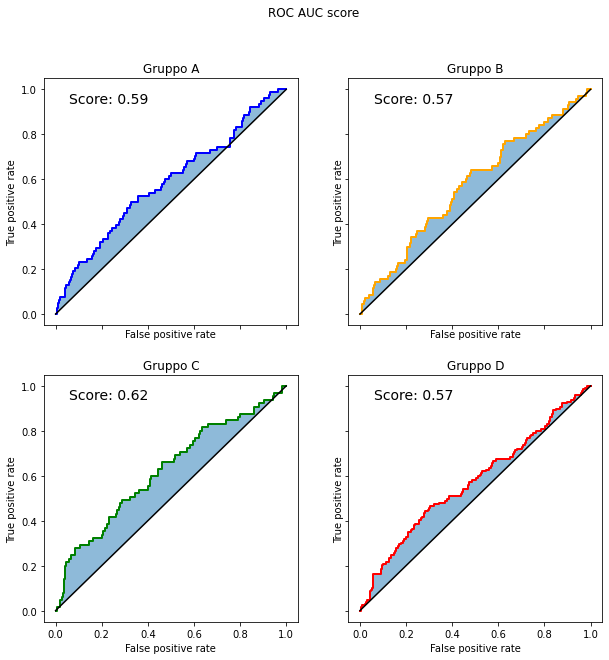

In [ ]:
#gruppo A
roc_aucA = roc_auc_score(yA,dfm_A1.xA_scA.values)
fprA, tprA, thresholds = roc_curve(yA, dfm_A1.xA_scA.values)

#gruppo B
roc_aucB = roc_auc_score(yB,dfm_B1.xA_scB.values)
fprB, tprB, thresholdsB = roc_curve(yB, dfm_B1.xA_scB.values)

#gruppo C
roc_aucC = roc_auc_score(yC,dfm_C1.xA_scC.values)
fprC, tprC, thresholdsC = roc_curve(yC, dfm_C1.xA_scC.values)

#gruppo D
roc_aucD = roc_auc_score(yD,dfm_D1.xA_scD.values)
fprD, tprD, thresholdsD = roc_curve(yD, dfm_D1.xA_scD.values)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
fig.suptitle('ROC AUC score')

ax1.plot(fprA, tprA, lw = 2, color = 'blue')
ax1.plot(fprA, fprA, color = 'black', ls = '-')
xarrA = np.linspace(0, 1, len(fprA))
ax1.fill_between(x = fprA, y1 = fprA, y2 = tprA, alpha = 0.5)
ax1.annotate(s = f'Score: {roc_aucA:.2f}', xy = (0.1, 0.9), xycoords = 'axes fraction', fontsize = 14)
ax1.set_title('Gruppo A')

ax2.plot(fprB, tprB, lw = 2, color = 'orange')
ax2.plot(fprB, fprB, color = 'black', ls = '-')
xarr = np.linspace(0, 1, len(fprB))
ax2.fill_between(x = fprB, y1 = fprB, y2 = tprB, alpha = 0.5)
ax2.annotate(s = f'Score: {roc_aucB:.2f}', xy = (0.1, 0.9), xycoords = 'axes fraction', fontsize = 14)
ax2.set_title('Gruppo B')

ax3.plot(fprC, tprC, lw = 2, color = 'green')
ax3.plot(fprC, fprC, color = 'black', ls = '-')
xarr = np.linspace(0, 1, len(fprC))
ax3.fill_between(x = fprC, y1 = fprC, y2 = tprC, alpha = 0.5)
ax3.annotate(s = f'Score: {roc_aucC:.2f}', xy = (0.1, 0.9), xycoords = 'axes fraction', fontsize = 14)
ax3.set_title('Gruppo C')

ax4.plot(fprD, tprD, lw = 2, color = 'red')
ax4.plot(fprD, fprD, color = 'black', ls = '-')
xarr = np.linspace(0, 1, len(fprD))
ax4.fill_between(x = fprD, y1 = fprD, y2 = tprD, alpha = 0.5)
ax4.annotate(s = f'Score: {roc_aucD:.2f}', xy = (0.1, 0.9), xycoords = 'axes fraction', fontsize = 14)
ax4.set_title('Gruppo D')

for ax in fig.get_axes():
  ax.label_outer()
  ax.set(xlabel ='False positive rate', ylabel = 'True positive rate')


In [ ]:
llA = log_loss(yA,dfm_A1.xA_scA.values)
print(f'{llA:.2f}')

llB = log_loss(yB,dfm_B1.xA_scB.values)
print(f'{llB:.2f}')

llC = log_loss(yC,dfm_C1.xA_scC.values)
print(f'{llC:.2f}')

llD = log_loss(yD,dfm_D1.xA_scD.values)
print(f'{llD:.2f}')

In [ ]:
avgA = yA.mean()
avg_arrA = np.full(len(dfm_A1), avgA)
naive_llA = log_loss(yA, avg_arrA)

print(f'LogLoss naive: {naive_llA:.2f}, LogLoss modello: {llA:.2f}')

avgB = yB.mean()
avg_arrB = np.full(len(dfm_B1), avgB)
naive_llB = log_loss(yB, avg_arrB)

print(f'LogLoss naive: {naive_llB:.2f}, LogLoss modello: {llB:.2f}')

avgC = yC.mean()
avg_arrC = np.full(len(dfm_C1), avgC)
naive_llC = log_loss(yC, avg_arrC)

print(f'LogLoss naive: {naive_llC:.2f}, LogLoss modello: {llC:.2f}')

avgD = yD.mean()
avg_arrD = np.full(len(dfm_D1), avgD)
naive_llD = log_loss(yD, avg_arrD)

print(f'LogLoss naive: {naive_llD:.2f}, LogLoss modello: {llD:.2f}')


[]

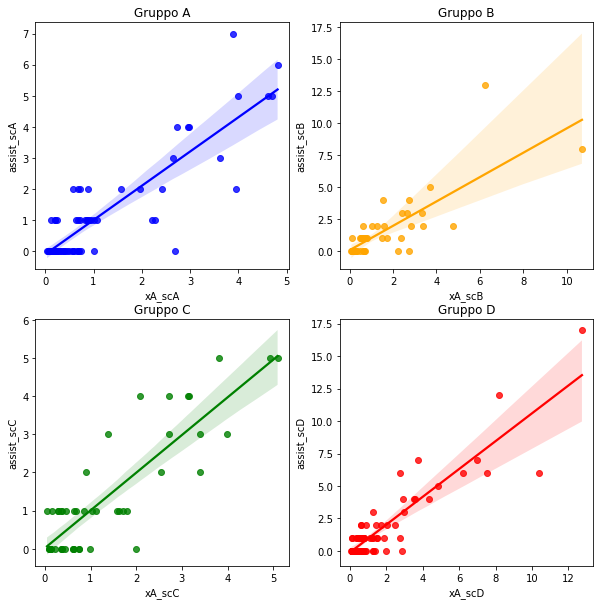

<Figure size 504x504 with 0 Axes>

In [ ]:
dfgA = dfm_A1.groupby('Giocatori')[['assist_scA', 'xA_scA']].sum()
dfgB = dfm_B1.groupby('Giocatori')[['assist_scB', 'xA_scB']].sum()
dfgC = dfm_C1.groupby('Giocatori')[['assist_scC', 'xA_scC']].sum()
dfgD = dfm_D1.groupby('Giocatori')[['assist_scD', 'xA_scD']].sum()


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
sns.regplot(data = dfgA, x = 'xA_scA', y = 'assist_scA', color = 'blue', ax=ax1)
ax1.set_title('Gruppo A')
ax1.plot()


plt.figure(figsize = (7,7))
sns.regplot(data = dfgB, x = 'xA_scB', y = 'assist_scB', color = 'orange', ax = ax2)
ax2.set_title('Gruppo B')
ax2.plot()

sns.regplot(data = dfgC, x = 'xA_scC', y = 'assist_scC', color = 'green', ax = ax3)
ax3.set_title('Gruppo C')
ax3.plot()


sns.regplot(data = dfgD, x = 'xA_scD', y = 'assist_scD', color = 'red', ax = ax4)
ax4.set_title('Gruppo D')
ax4.plot()


In [ ]:
print(dfgA.corr()**2)

print(dfgB.corr()**2)

print(dfgC.corr()**2)

print(dfgD.corr()**2)

CONFRONTO IN BASE A GIOCATORI E SQUADRE

In [ ]:
dfm_xA_totA_P100 = dfm_A1['xA_scA'].sum()/(dfm_A1['n_eventi'].sum())*100

print(f'Il gruppo A genera {dfm_xA_totA_P100:.2f}')

dfm_xA_totB_P100 = dfm_B1['xA_scB'].sum()/(dfm_B1['n_eventi'].sum())*100

print(f'Il gruppo B genera {dfm_xA_totB_P100:.2f}')

dfm_xA_totC_P100 = dfm_C1['xA_scC'].sum()/(dfm_C1['n_eventi'].sum())*100

print(f'Il gruppo C genera {dfm_xA_totC_P100:.2f}')

dfm_xA_totD_P100 = dfm_D1['xA_scD'].sum()/(dfm_D1['n_eventi'].sum())*100

print(f'Il gruppo D genera {dfm_xA_totD_P100:.2f}')


Il gruppo A genera 10.13
Il gruppo B genera 13.23
Il gruppo C genera 11.36
Il gruppo D genera 14.93


In [ ]:
dfm_A12 = dfm_A1.groupby(['Giocatori']).sum()

dfm_A12['xA_scA_P100'] = dfm_A12['xA_scA']/dfm_A12['n_eventi']*100.
dfm_A13 = dfm_A12[dfm_A12.n_eventi >= 10.]

dfm_A13['xA_scA_P100_rank'] = dfm_A13.xA_scA_P100.rank(ascending = False)
dfm_A14 = dfm_A13.sort_values('xA_scA_P100_rank').head(10)[['n_eventi','xA_scA_P100', 'xA_scA_P100_rank']]

dfm_B12 = dfm_B1.groupby(['Giocatori']).sum()

dfm_B12['xA_scB_P100'] = dfm_B12['xA_scB']/dfm_B12['n_eventi']*100.
dfm_B13 = dfm_B12[dfm_B12.n_eventi >= 10.]

dfm_B13['xA_scB_P100_rank'] = dfm_B13.xA_scB_P100.rank(ascending = False)
dfm_B14 = dfm_B13.sort_values('xA_scB_P100_rank').head(10)[['n_eventi','xA_scB_P100', 'xA_scB_P100_rank']]

dfm_C12 = dfm_C1.groupby(['Giocatori']).sum()

dfm_C12['xA_scC_P100'] = dfm_C12['xA_scC']/dfm_C12['n_eventi']*100.
dfm_C13 = dfm_C12[dfm_C12.n_eventi >= 10.]

dfm_C13['xA_scC_P100_rank'] = dfm_C13.xA_scC_P100.rank(ascending = False)
dfm_C14 = dfm_C13.sort_values('xA_scC_P100_rank').head(10)[['n_eventi','xA_scC_P100', 'xA_scC_P100_rank']]

dfm_D12 = dfm_D1.groupby(['Giocatori']).sum()

dfm_D12['xA_scD_P100'] = dfm_D12['xA_scD']/dfm_D12['n_eventi']*100.
dfm_D13 = dfm_D12[dfm_D12.n_eventi >= 10.]

dfm_D13['xA_scD_P100_rank'] = dfm_D13.xA_scD_P100.rank(ascending = False)
dfm_D14 = dfm_D13.sort_values('xA_scD_P100_rank').head(10)[['n_eventi','xA_scD_P100', 'xA_scD_P100_rank']]


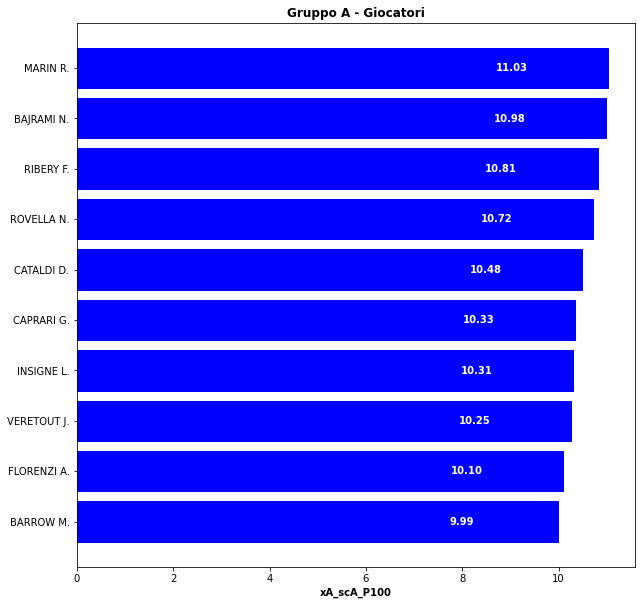

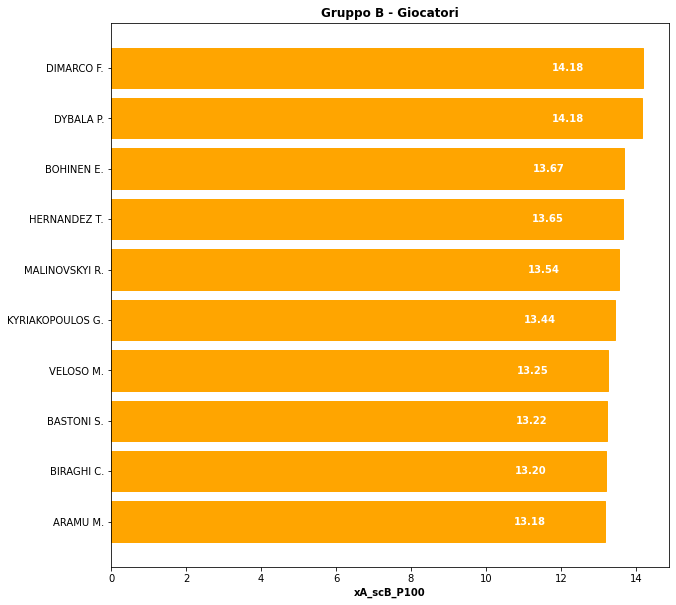

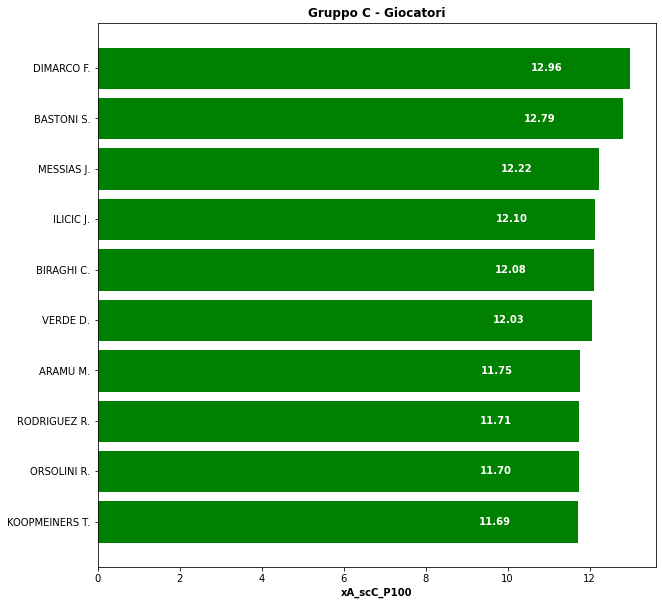

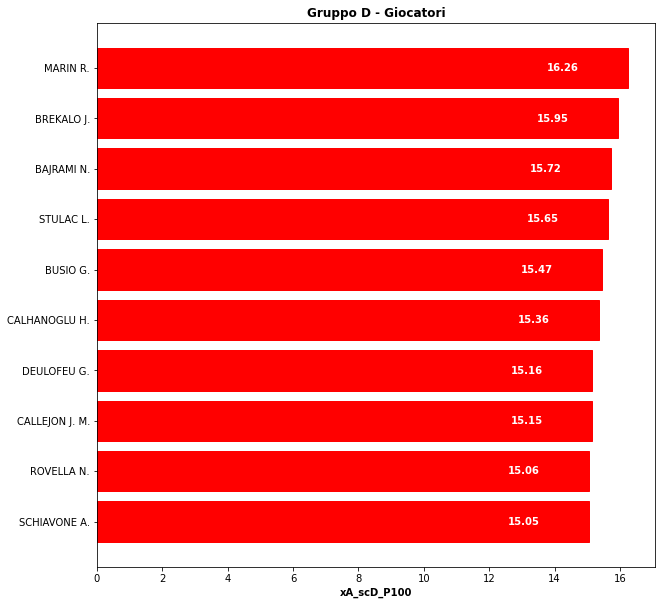

In [ ]:
plt.figure(figsize = (10,10))
ax = plt.gca()
plt.barh(y = dfm_A14.index, width = dfm_A14['xA_scA_P100'], color = 'b', ec = 'b')
for i,r in dfm_A14.iterrows():
  value = r['xA_scA_P100']
  plt.annotate(s = f'{value:.2f}', xy = (value-2, i), horizontalalignment = 'center', verticalalignment = 'center', weight = 'bold', color = 'w')
plt.yticks(dfm_A14.index)
plt.xlabel('xA_scA_P100', weight = 'bold')
ax.invert_yaxis()
plt.title('Gruppo A - Giocatori', weight = 'bold')
plt.show()

plt.figure(figsize = (10,10))
ax = plt.gca()
plt.barh(y = dfm_B14.index, width = dfm_B14['xA_scB_P100'], color = 'orange', ec = 'orange')
for i,r in dfm_B14.iterrows():
  value = r['xA_scB_P100']
  plt.annotate(s = f'{value:.2f}', xy = (value-2, i), horizontalalignment = 'center', verticalalignment = 'center', weight = 'bold', color = 'w')
plt.yticks(dfm_B14.index)
plt.xlabel('xA_scB_P100', weight = 'bold')
ax.invert_yaxis()
plt.title('Gruppo B - Giocatori', weight = 'bold')
plt.show()

plt.figure(figsize = (10,10))
ax = plt.gca()
plt.barh(y = dfm_C14.index, width = dfm_C14['xA_scC_P100'], color = 'g', ec = 'g')
for i,r in dfm_C14.iterrows():
  value = r['xA_scC_P100']
  plt.annotate(s = f'{value:.2f}', xy = (value-2, i), horizontalalignment = 'center', verticalalignment = 'center', weight = 'bold', color = 'w')
plt.yticks(dfm_C14.index)
plt.xlabel('xA_scC_P100', weight = 'bold')
ax.invert_yaxis()
plt.title('Gruppo C - Giocatori', weight = 'bold')
plt.show()

plt.figure(figsize = (10,10))
ax = plt.gca()
plt.barh(y = dfm_D14.index, width = dfm_D14['xA_scD_P100'], color = 'R', ec = 'R')
for i,r in dfm_D14.iterrows():
  value = r['xA_scD_P100']
  plt.annotate(s = f'{value:.2f}', xy = (value-2, i), horizontalalignment = 'center', verticalalignment = 'center', weight = 'bold', color = 'w')
plt.yticks(dfm_D14.index)
plt.xlabel('xA_scD_P100', weight = 'bold')
ax.invert_yaxis()
plt.title('Gruppo D - Giocatori', weight = 'bold')
plt.show()


In [ ]:
dfm_A12 = dfm_A1.groupby(['Squadra']).sum()

dfm_A12['xA_scA_P100'] = dfm_A12['xA_scA']/dfm_A12['n_eventi']*100.

dfm_A12['xA_scA_P100_rank'] = dfm_A12.xA_scA_P100.rank(ascending = False)
dfm_A13s = dfm_A12.sort_values('xA_scA_P100_rank').head(20)[['n_eventi','xA_scA_P100', 'xA_scA_P100_rank']]

dfm_B12 = dfm_B1.groupby(['Squadra']).sum()

dfm_B12['xA_scB_P100'] = dfm_B12['xA_scB']/dfm_B12['n_eventi']*100.

dfm_B12['xA_scB_P100_rank'] = dfm_B12.xA_scB_P100.rank(ascending = False)
dfm_B13s = dfm_B12.sort_values('xA_scB_P100_rank').head(20)[['n_eventi','xA_scB_P100', 'xA_scB_P100_rank']]

dfm_C12 = dfm_C1.groupby(['Squadra']).sum()

dfm_C12['xA_scC_P100'] = dfm_C12['xA_scC']/dfm_C12['n_eventi']*100.

dfm_C12['xA_scC_P100_rank'] = dfm_C12.xA_scC_P100.rank(ascending = False)
dfm_C13s = dfm_C12.sort_values('xA_scC_P100_rank').head(20)[['n_eventi','xA_scC_P100', 'xA_scC_P100_rank']]

dfm_D12 = dfm_D1.groupby(['Squadra']).sum()

dfm_D12['xA_scD_P100'] = dfm_D12['xA_scD']/dfm_D12['n_eventi']*100.

dfm_D12['xA_scD_P100_rank'] = dfm_D12.xA_scD_P100.rank(ascending = False)
dfm_D13s = dfm_D12.sort_values('xA_scD_P100_rank').head(20)[['n_eventi','xA_scD_P100', 'xA_scD_P100_rank']]


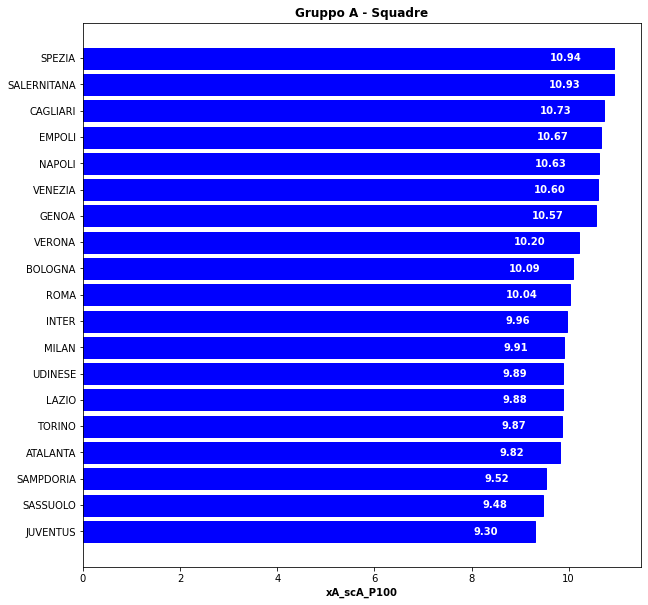

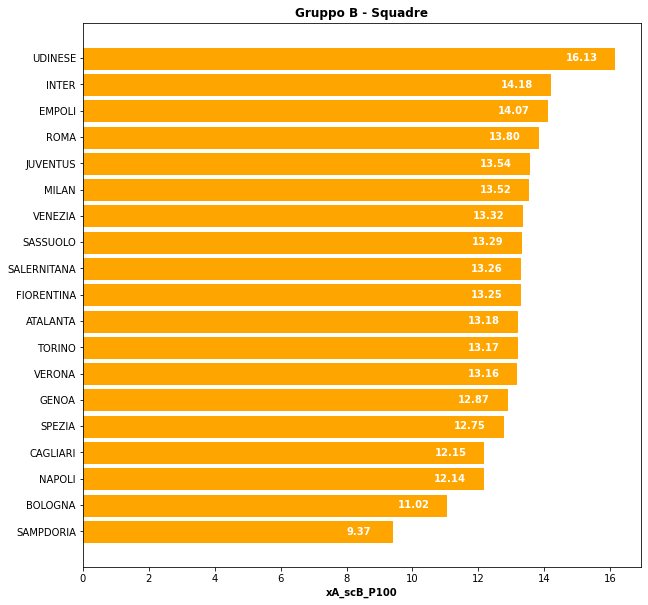

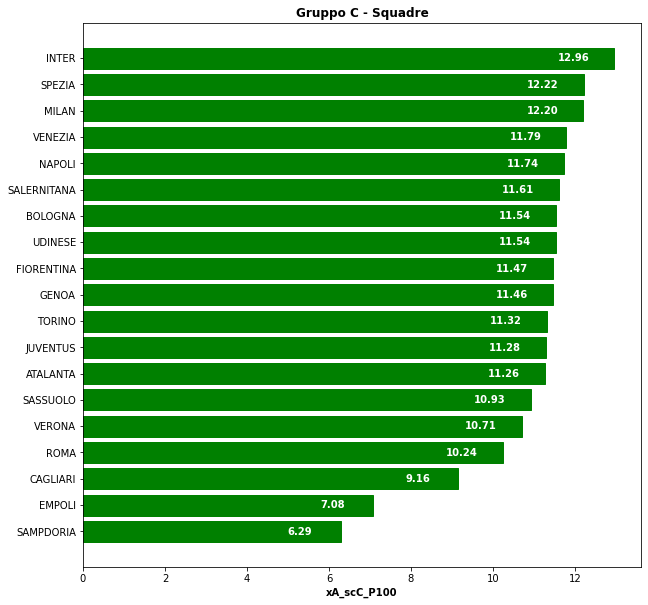

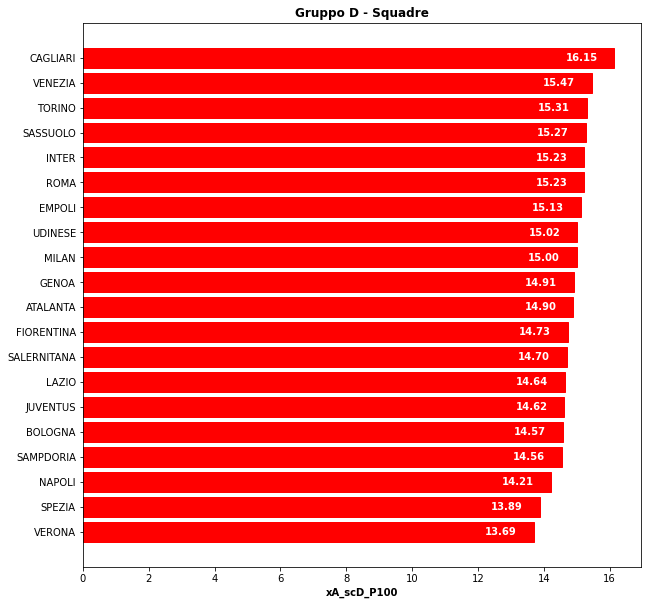

In [ ]:
plt.figure(figsize = (10,10))
ax = plt.gca()
plt.barh(y = dfm_A13s.index, width = dfm_A13s['xA_scA_P100'], color = 'blue', ec = 'blue')
for i,r in dfm_A13s.iterrows():
  value = r['xA_scA_P100']
  plt.annotate(s = f'{value:.2f}', xy = (value-1, i), horizontalalignment = 'center', verticalalignment = 'center', weight = 'bold', color = 'w')
plt.yticks(dfm_A13s.index)
plt.xlabel('xA_scA_P100', weight = 'bold')
ax.invert_yaxis()
plt.title('Gruppo A - Squadre', weight = 'bold')
plt.show()


plt.figure(figsize = (10,10))
ax = plt.gca()
plt.barh(y = dfm_B13s.index, width = dfm_B13s['xA_scB_P100'], color = 'orange', ec = 'orange')
for i,r in dfm_B13s.iterrows():
  value = r['xA_scB_P100']
  plt.annotate(s = f'{value:.2f}', xy = (value-1, i), horizontalalignment = 'center', verticalalignment = 'center', weight = 'bold', color = 'w')
plt.yticks(dfm_B13s.index)
plt.xlabel('xA_scB_P100', weight = 'bold')
ax.invert_yaxis()
plt.title('Gruppo B - Squadre', weight = 'bold')
plt.show()


plt.figure(figsize = (10,10))
ax = plt.gca()
plt.barh(y = dfm_C13s.index, width = dfm_C13s['xA_scC_P100'], color = 'g', ec = 'g')
for i,r in dfm_C13s.iterrows():
  value = r['xA_scC_P100']
  plt.annotate(s = f'{value:.2f}', xy = (value-1, i), horizontalalignment = 'center', verticalalignment = 'center', weight = 'bold', color = 'w')
plt.yticks(dfm_C13s.index)
plt.xlabel('xA_scC_P100', weight = 'bold')
ax.invert_yaxis()
plt.title('Gruppo C - Squadre', weight = 'bold')
plt.show()


plt.figure(figsize = (10,10))
ax = plt.gca()
plt.barh(y = dfm_D13s.index, width = dfm_D13s['xA_scD_P100'], color = 'R', ec = 'R')
for i,r in dfm_D13s.iterrows():
  value = r['xA_scD_P100']
  plt.annotate(s = f'{value:.2f}', xy = (value-1, i), horizontalalignment = 'center', verticalalignment = 'center', weight = 'bold', color = 'w')
plt.yticks(dfm_D13s.index)
plt.xlabel('xA_scD_P100', weight = 'bold')
ax.invert_yaxis()
plt.title('Gruppo D - Squadre', weight = 'bold')
plt.show()

